In [1]:
import math
import numpy as np
import os
import pyro
import pyro.contrib.gp as gp
import scipy.special as sc
import scipy.stats as stats
import torch

from copy import deepcopy
from sklearn.cluster import KMeans
from torch.optim import Adam


class GPSparseBayesModel():
  """Wraps Pyro's SparseVariationGP Gaussian Process bayesian model.

  See https://docs.pyro.ai/en/stable/contrib.gp.html for more info.

  Kernel arg can take values "rbf", "linear", or "poly" corresponding to
  Pyro's RBF, Linear, or Polynomial kernels respectively. Other Pyro kernels
  not yet implemented. Bayesian prior is parameterized by kernel_params. See
  above link for more info on kernel params.
  """
  def __init__(self, **kwargs):
    self.kernel = kwargs.get("kernel", "rbf")
    self.kernel_params = kwargs.get("kernel_params", {})
    self.learning_rate = kwargs.get("learning_rate", 0.01)
    self.num_steps = kwargs.get("num_steps", 1000)
    self.loss = kwargs.get("loss", "trace_meanfield_elbo")
    self.num_induced_samples = kwargs.get("num_induced_samples", "sqrt")
    self.induced_points_method = kwargs.get("induced_points_method", "kmeans")
    self.random_seed = kwargs.get("random_seed", None)
    self.max_intra_op_threads = kwargs.get("max_intra_op_threads", None)
    self.max_interop_threads = kwargs.get("max_interop_threads", None)
    self.max_omp_threads = kwargs.get("max_omp_threads", None)

  def after_setup(self):
    self.rng = np.random.default_rng(self.random_seed)

    # Allow control of number of threads used. Rather than trying to find an
    # intelligent way to guarantee a maximum thread size is not exceeded, we
    # allow fine grained control over different options for controlling pytorch
    # cpu threading. See
    # https://pytorch.org/docs/stable/notes/cpu_threading_torchscript_inference.html
    if self.max_intra_op_threads is not None:
      torch.set_num_threads(self.max_intra_op_threads)
    if self.max_interop_threads is not None:
      num_interop_threads = torch.get_num_interop_threads()
      if num_interop_threads != self.max_interop_threads:
        torch.set_num_interop_threads(self.max_interop_threads)
    if self.max_omp_threads is not None:
      os.environ["OMP_NUM_THREADS"] = str(self.max_omp_threads)

    # Some parameters should be passed to the underlying model as torch
    # tensors. User of ConfidenceGPBayes should pass lists which are
    # converted to torch tensors below.
    self.__kernel_params = deepcopy(self.kernel_params)
    for param in "variance", "lengthscale", "bias":
      if param in self.__kernel_params:
        if not isinstance(self.__kernel_params[param], torch.Tensor):
          self.__kernel_params[param] = torch.tensor(self.__kernel_params[param])

  def train(self, X, y):
    # Set torch seed, choosing value with numpy random generator.
    max_int = np.iinfo(np.int32).max
    seed = self.rng.integers(max_int)
    torch.manual_seed(seed)

    # Param store must be cleared between fittings if model is to be fit
    # multiple times
    pyro.clear_param_store()

    n, p = X.shape
    # Implementation does not work with boolean response value. Convert
    # to floats 1.0, 0.0
    y = y.astype(float)
    # Maps kernel input strings to actual kernel classes. We cannot pass kernel
    # classes in a template because they are not json serializable.
    kernel_class = {
      "rbf": gp.kernels.RBF,
      "linear": gp.kernels.Linear,
      "poly": gp.kernels.Polynomial,
    }[self.kernel]
    kernel = kernel_class(input_dim=p, **self.__kernel_params)
    if self.loss == "trace_meanfield_elbo":
      loss_function = pyro.infer.TraceMeanField_ELBO().differentiable_loss
    elif self.loss == "trace_elbo":
      loss_function = pyro.infer.Trace_ELBO().differentiable_loss

    num_induced_samples = (math.ceil(math.sqrt(n))
        if self.num_induced_samples == "sqrt" else self.num_induced_samples)

    if self.induced_points_method == "random":
      Xu = X[self.rng.choice(n, size=num_induced_samples, replace=False), :]
    elif self.induced_points_method == "kmeans":
      seed = self.rng.integers(max_int)
      kmeans = KMeans(n_clusters=num_induced_samples, random_state=seed).fit(X)
      Xu = kmeans.cluster_centers_

    X, y, Xu = map(torch.from_numpy, (X, y, Xu))
    estimator = gp.models.VariationalSparseGP(X, y, kernel, Xu,
      likelihood=gp.likelihoods.Binary())

    optimizer = Adam(estimator.parameters(), lr=self.learning_rate)
    losses = gp.util.train(
      estimator,
      optimizer=optimizer,
      loss_fn=loss_function,
      num_steps=self.num_steps
    )
    self.estimator = estimator
    self.losses = losses
    self.classes = np.unique(y.detach().numpy())

  def test(self, X, y):
    X = torch.from_numpy(X)
    f_loc, f_var = self.estimator(X)
    f_loc, f_var = map(lambda x: x.detach().numpy(), (f_loc, f_var))
    probs = logit_normal_moments(f_loc, f_var, order=1)
    second_moments = logit_normal_moments(f_loc, f_var, order=2)
    variances = second_moments - probs**2
    # Convert labels back to bools
    labels = np.where(probs >= 0.5, True, False)
    return probs, variances, labels


def logit_normal_moments(loc, scale, order=1, num_samples=10000):
  """Computes moments of logit normal distribution.

    Uses a Quasi monte-carlo estimate. This is needed to map predictions on
  the log-odds scale to predicted means and variances on the probability scale.

  See https://en.wikipedia.org/wiki/Logit-normal_distribution#Moments.

  Parameters
  ----------
  loc : float
    Location parameter of a logit normal distribution
  scale : float
    Scale parameter of a logit normal distribution
  order : Optional[int]
    Order of moment to compute. 1 for mean, 2 for second moment. Default: 1
  num_samples : Optional[int]
    Number of samples to use in quasi-monte carlo algorithm. Default: 10000

  Returns
  -------
  float
    Specified moment of specified logit normal distribution.
  """
  result = np.zeros(loc.shape)
  for i in range(1, num_samples):
    result += sc.expit(
      stats.norm.ppf(i / num_samples, loc=loc, scale=scale)
    )**order
  return result / (num_samples - 1)


In [28]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def ause(pred_probs, pred_variances, true_labels):
    num_pred = pred_probs.shape[0]
    error_res = (true_labels - pred_probs)**2
    idx_res = np.argsort(error_res)
    idx_var = np.argsort(pred_variances)
    fractions = list(np.arange(start=0.,stop=1.,step=0.01))
    var_rmses, error_rmses = [], []
    for step, fraction in enumerate(fractions):
        var_rmse = np.sqrt(np.mean(error_res[idx_var[0:int((1.-fraction)*num_pred)]]))
        var_rmses.append(var_rmse)
        
        error_rmse = np.sqrt(np.mean(error_res[idx_res[0:int((1.-fraction)*num_pred)]]))
        error_rmses.append(error_rmse)
    error_rmses_normalized = error_rmses/error_rmses[0]
    var_rmses_normalized = var_rmses/var_rmses[0]
    sparsification_errors = var_rmses_normalized - error_rmses_normalized
    plt.plot(fractions, error_rmses_normalized)
    plt.plot(fractions, var_rmses_normalized)
    plt.show()
    ause = np.trapz(y=sparsification_errors, x=fractions)
    return ause

def process_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7200)
    X_train, y_train = X_train.to_numpy(), y_train.to_numpy().ravel()
    X_test, y_test = X_test.to_numpy(), y_test.to_numpy().ravel()
    model = GPSparseBayesModel(**{"random_seed": 7200, "induced_points_method": "random", "num_induced_samples": 'sqrt'})
    model.after_setup()
    model.train(X_train, y_train)
    res = model.test(X_test, None)
    probs, variances, labels = res
    print(accuracy_score(y_test, labels))
    ause(probs, variances, labels)
    ause(probs, np.random.permutation(variances), labels)

0.7922077922077922


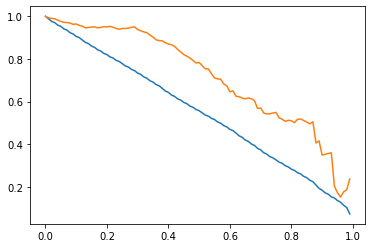

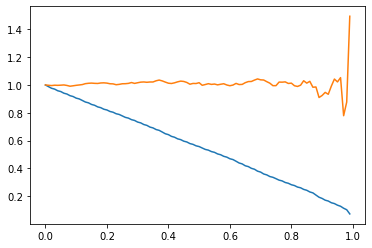

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("data/diabetes.csv")

X, y = data[["Pregnancies", "Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]], data[['Outcome']]
process_data(X, y)

0.8169014084507042


C:\Users\divya\anaconda3\envs\venv\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\divya\anaconda3\envs\venv\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


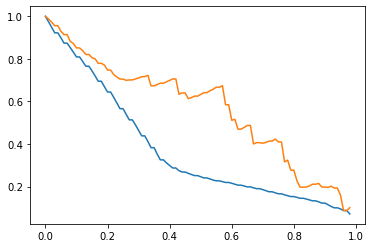

C:\Users\divya\anaconda3\envs\venv\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\divya\anaconda3\envs\venv\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


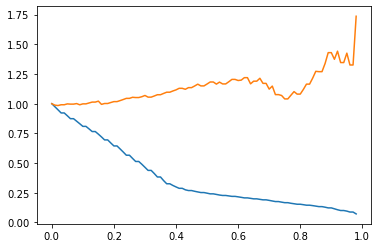

In [49]:
data2 = pd.read_csv('data/ionosphere.data', header=None)
data2['label'] = data2[34] == 'g'
X, y = data2.iloc[:, :34], data2['label']
process_data(X, y)